### Read in and plot the data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from random import sample

In [2]:
class PlotData():
    def __init__(self, figsize=(8,10)):
        self.fig = plt.figure(figsize=figsize)
        self.scatter_lim_x, self.scatter_lim_y = (4,25), (-5,25)

    def plot_line(self, X, y, p, use_ax, title="Training Data and Predicted Values, Normal Eq.",
                                    xlabel="Training Input", ylabel="Target/Predicted"):
        """Plot raw data and line prediction in one plot."""
        
        # plot
        ax = self.fig.add_subplot(*use_ax)
        ax.scatter(X, y)
        ax.plot(X, p, 'r')
        # format
        ax.grid(True)
        # add title
        ax.set(title=title, xlabel=xlabel, ylabel=ylabel)
        
    def plot_scatter(self, X, y, use_ax, title="Raw Data, X vs. y"):
        """Plot raw data in a scatter plot."""

        ax = self.fig.add_subplot(*use_ax)
        # plot
        ax.scatter(X,y)

        # format
        ax.set(xlim=self.scatter_lim_x, ylim=self.scatter_lim_y)
        ax.grid(True)
        # add title
        ax.set_title(title)

plot = PlotData()


<Figure size 800x1000 with 0 Axes>

# Normal Coefficient Regression

In [3]:
class NormalRegCoeffs():
    def __init__(self, df):
        
        self.m = df.shape[0]
        self.X = df[0].to_numpy().reshape(self.m,1)
        self.y = df[1].to_numpy().reshape(self.m,1)
        self.plot = PlotData()
        
    def predict(self, X, w):
        return X.dot(w)
        
    def get_coeff_norm(self, X, y):
        a,b = X.T.dot(X), X.T.dot(y)
        return np.linalg.inv(a).dot(b)
        
    def main(self):
        bias_X = np.append(self.X, np.ones((self.m,1)), axis=1)
        
        w = self.get_coeff_norm(bias_X, self.y)
        
        p = self.predict(bias_X, w)
        
        print("Linear model: y = w0 + w1*x\n" \
             f"Predicted regression coefficients: {w[0][0]:.4}, {w[1][0]:.4}\n")
        
        self.plot.plot_scatter(self.X, self.y, (2,1,1))
        self.plot.plot_line(self.X, self.y, p, (2,1,2))

        plt.show()


Linear model: y = w0 + w1*x
Predicted regression coefficients: 1.193, -3.896



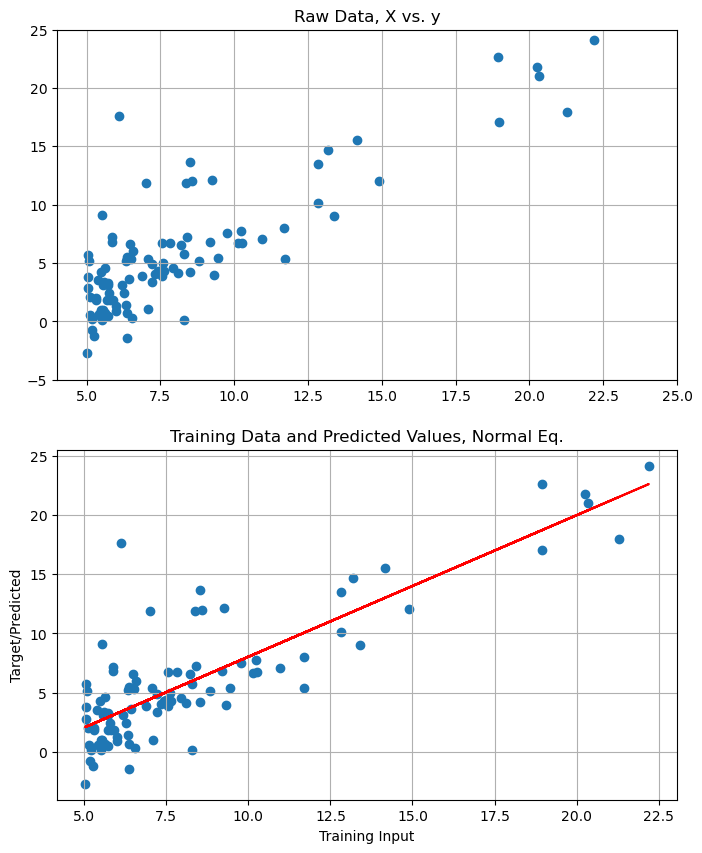

In [4]:

filepath = 'data.txt'
df = pd.read_csv(filepath, header = None, delimiter = ",")

norms = NormalRegCoeffs(df)
norms.main()

mode = ["batch", "stochastic"]

# Gradient Descent Models

In [5]:
class LinGD():
    def __init__(self):
        self.learning_rate = 1e-10
        self.epochs = 10000
        
    def yhat(self, X, w):
        return np.dot(w.T, X)
    
    def loss(self, yhat, y):
        L = 1/self.m * np.sum(np.power(yhat - y, 2))
        return L
        
    def gradient_descent(self, w, X, y, yhat):
        dldw = 2/self.m * np.dot(X, (yhat-y).T)
        w = w - self.learning_rate*dldw
        return w
        
    def main(self,X,y):
        x1 = np.ones((1, X.shape[1]))
        X = np.append(X, x1, axis=0)
        
        self.m = X.shape[1]
        self.n = X.shape[0]
        
        w = np.zeros((self.n, 1))
        
        for epoch in range(self.epochs+1):
            yhat = self.yhat(X,w)
            loss = self.loss(yhat, y)
            
            if epoch % 2000 == 0:
                print(f'cost at epoch {epoch} is {loss:.8}')
                
            w = self.gradient_descent(w, X, y, yhat)
            
        return w
    
Xg = np.random.rand(1,500)
yg = 3*Xg + np.random.randn(1,500)*0.1

reg = LinGD()
eg = reg.main(Xg,yg)

cost at epoch 0 is 2.9648475
cost at epoch 2000 is 2.9648449
cost at epoch 4000 is 2.9648423
cost at epoch 6000 is 2.9648398
cost at epoch 8000 is 2.9648372
cost at epoch 10000 is 2.9648346


In [6]:


class GradientDescent():
    def __init__(self, learn=1e-3, epochs=1000, tol=1e-4):
        self.epochs = epochs
        self.learn = learn
        self.tol = tol

    def prediction(self, X, w):
        return np.dot(w.T, X)

    def MSE(self, error, m):
        return 1/m*(error**2).sum()

    def descent(self, X, error, N):
        dfdw = 2/N*X.dot(error.T)
        # return negative gradient direction scaled by learning rate
        return -self.learn*dfdw

    def get_coeff_BGD(self, X, y, m, m_test, N, start, X_test, y_test):
        
        X = np.append(X, np.ones((1, m)), axis = 0)
        X_test = np.append(X_test, np.ones((1, m_test)), axis = 0)
        
        train_error = {}
        test_error = {}
        
        # initialize w vector as a random guess
        w = start
        
        for i in range(self.epochs+1):
            # calculate test/train error and store in dicts
            p_test = self.prediction(X_test, w)
            t_error = p_test - y_test
            
            p = self.prediction(X,w)
            error = p-y
            
            train_error[i] = self.MSE(error,m)
            test_error[i] = self.MSE(t_error,m)
            
            # find step size and adjust w vector
            delta = self.descent(X,error,N)
            
            # if rate of change is less than or eq to tolerance, end
            if np.all(np.abs(delta) <= self.tol):
                break
                
            w = w + delta
        return test_error, train_error, w, p 

    def get_coeff_SGD(self, X, y, m, m_test, start, X_test, y_test):
        X = np.append(X, np.ones((1, m)), axis = 0)
        X_test = np.append(X_test, np.ones((1, m_test)), axis = 0)
        
        train_error = {}
        test_error = {}
        
        # initialize w vector as a random guess
        w = start
        
        for i in range(self.epochs+1):
            p_test = self.prediction(X_test, w)
            t_error = p_test - y_test
            p = self.prediction(X,w)
            error = p-y
            
            train_error[i] = self.MSE(error,m)
            test_error[i] = self.MSE(t_error,m)
            
            pt = sample(list(range(m)),1)[0]
            dfdw = 2*np.dot(X[0][pt],error.T[pt])
            delta = -self.learn*dfdw
            
            if np.all(np.abs(delta) <= self.tol):
                break
                
            w = w + delta
            
        return test_error, train_error, w, p 
    
gd = GradientDescent()

## Stochastic Gradient Descent

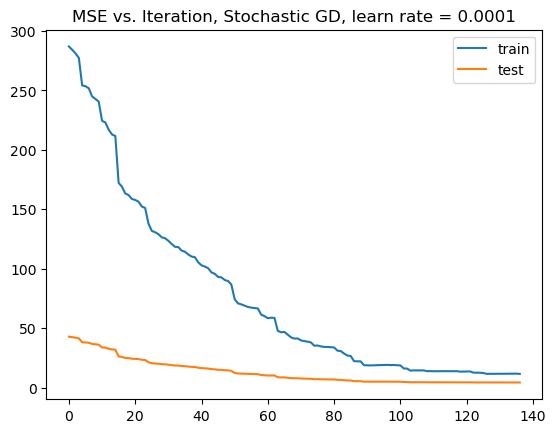

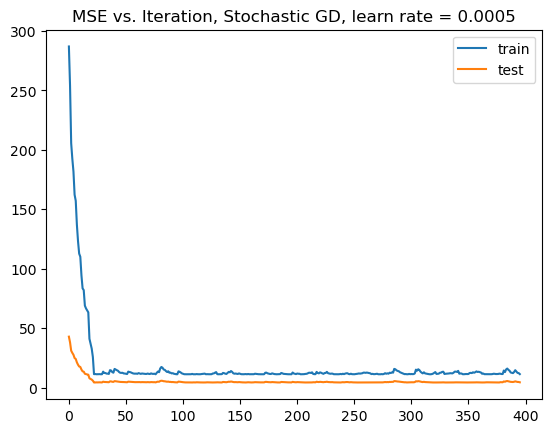

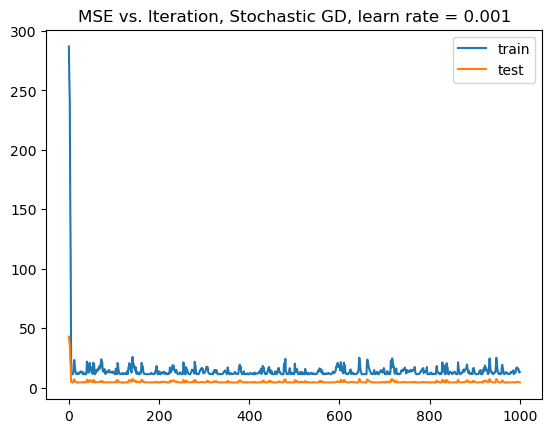

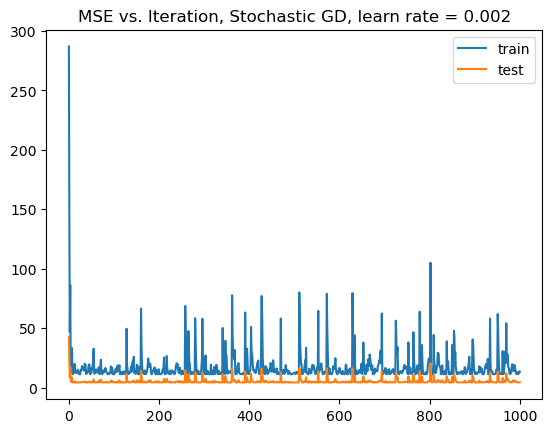

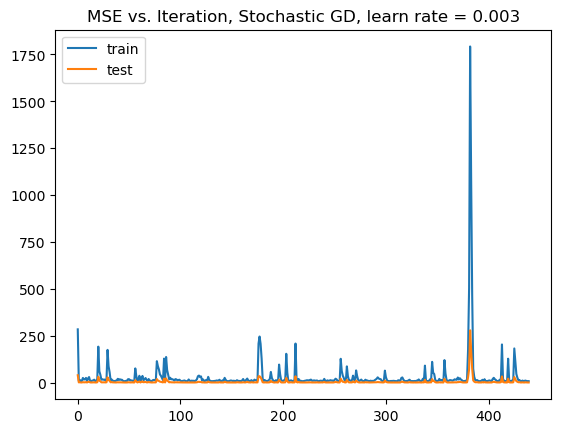

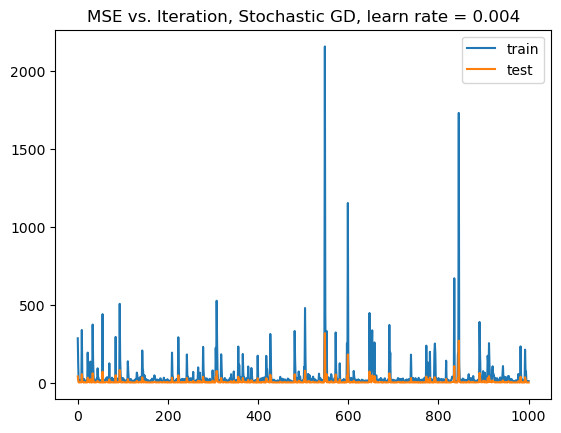

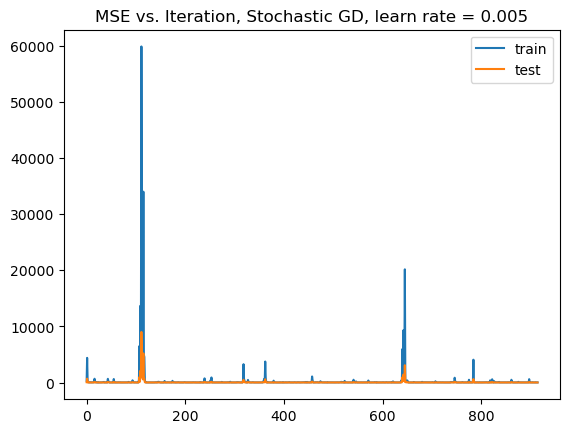

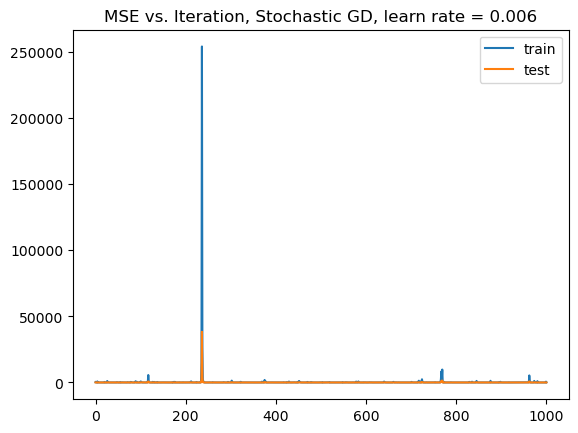

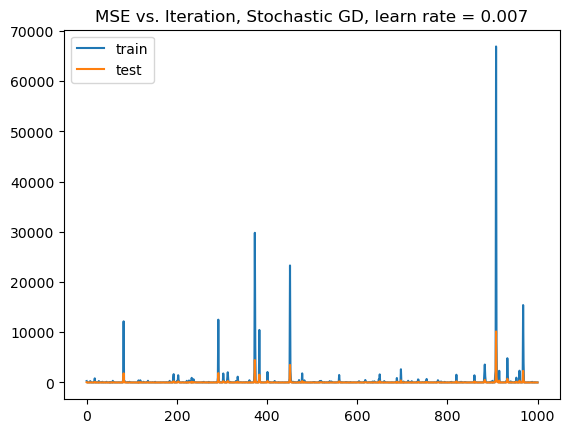

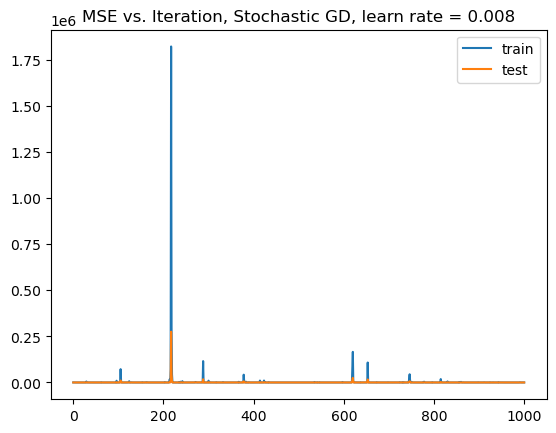

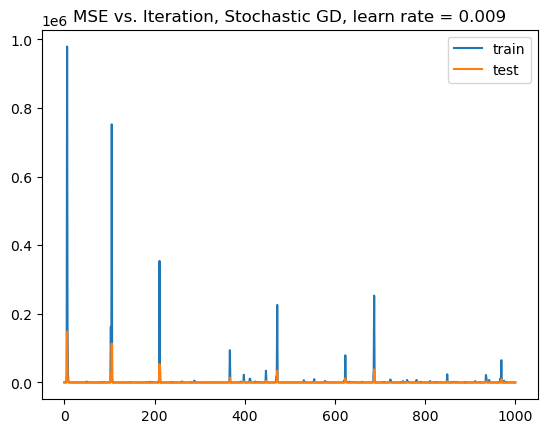

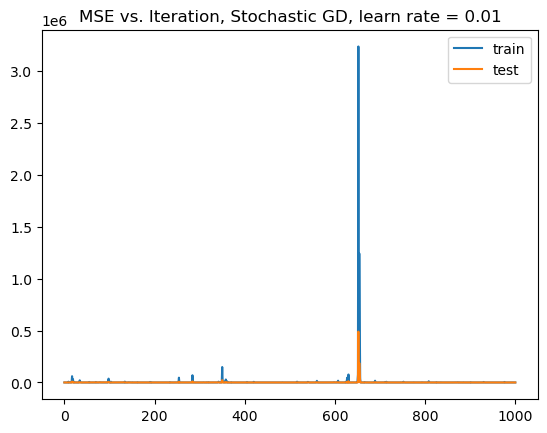

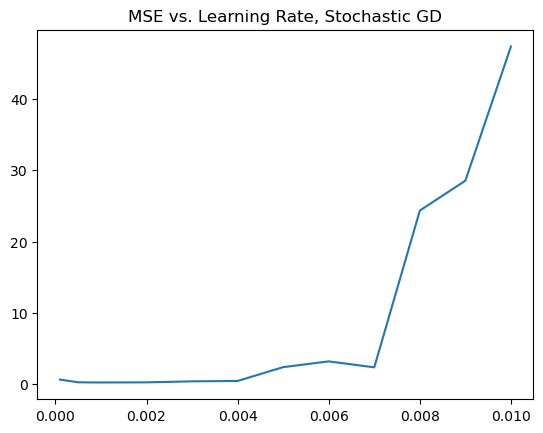

In [7]:

# intialize arrays for dataset as well as test/train set
X, y = df[0].to_numpy(), df[1].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

m_test, m_train = len(X_test), len(X_train)

X_train, y_train = X_train.reshape(1,m_train), y_train.reshape(1,m_train)
X_test, y_test = X_test.reshape(1,m_test), y_test.reshape(1,m_test)

rates = [0.0001, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01]
start = np.random.randn(2,1)

mse_test_s = {}

gd = GradientDescent()

for learn in rates:
    gd.learn = learn
    ## stochastic GD
    s_test,s_train, stochastic, pred_s = gd.get_coeff_SGD(X_train, y_train, m_train, m_test,
                                                       start, X_test, y_test)
    
    mse_error = np.mean(list(s_test.values()))/m_test
    mse_test_s[learn] = mse_error
    
    plt.plot(s_train.keys(), s_train.values(), label = 'train')
    plt.plot(s_test.keys(), s_test.values(), label = 'test')
    plt.title(f'MSE vs. Iteration, Stochastic GD, learn rate = {learn}')
    plt.legend()
    plt.show()
    
plt.plot(mse_test_s.keys(),mse_test_s.values())   
plt.title(f'MSE vs. Learning Rate, Stochastic GD')
plt.show()

## Batch Gradient Descent

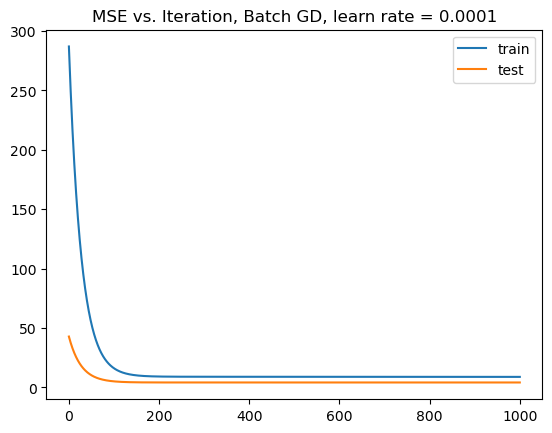

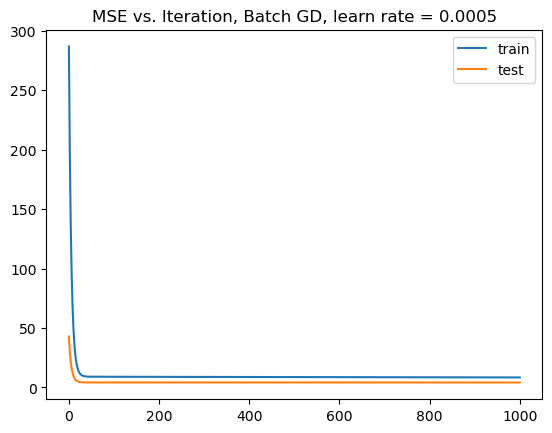

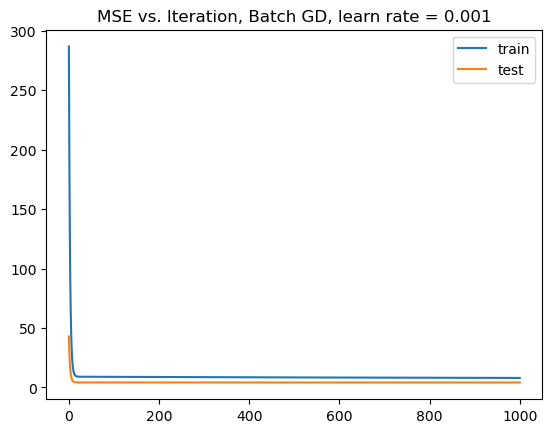

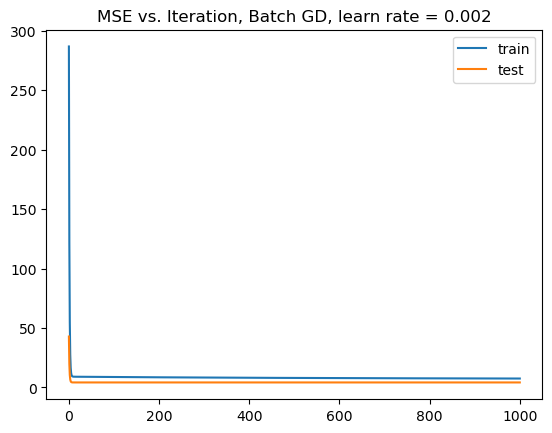

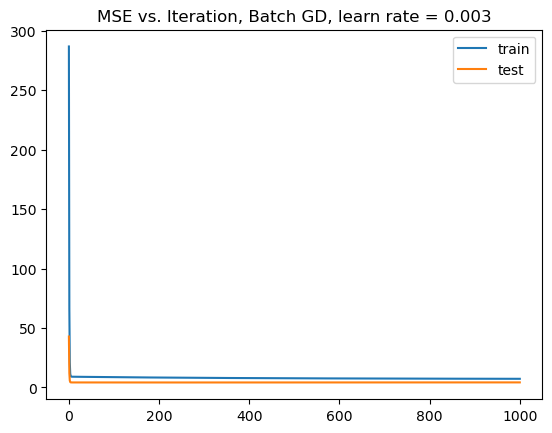

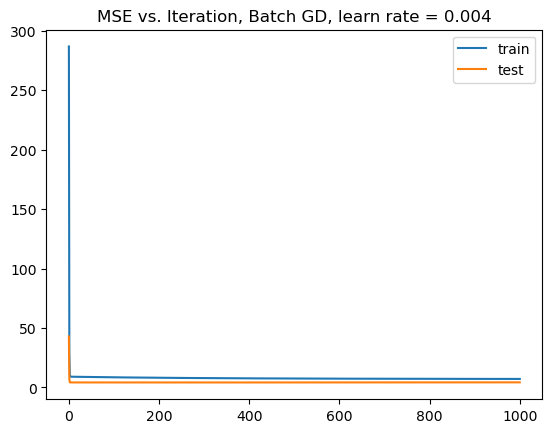

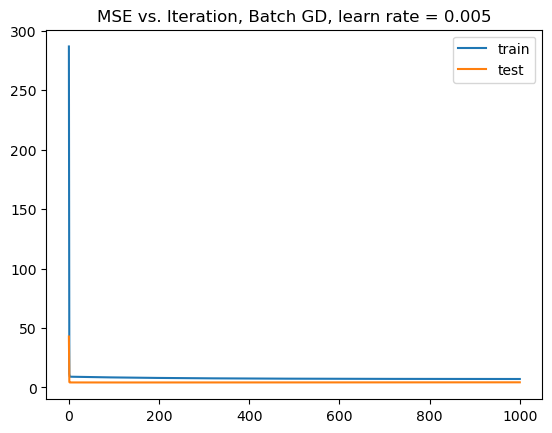

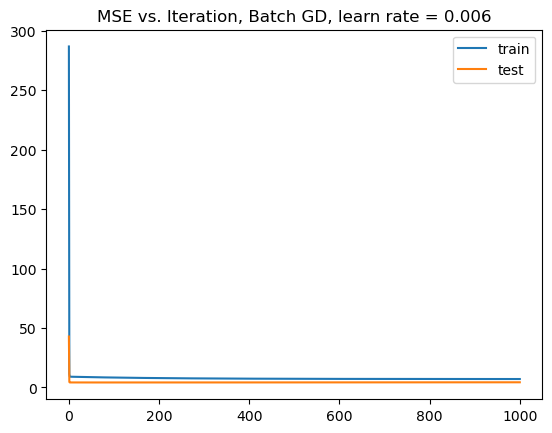

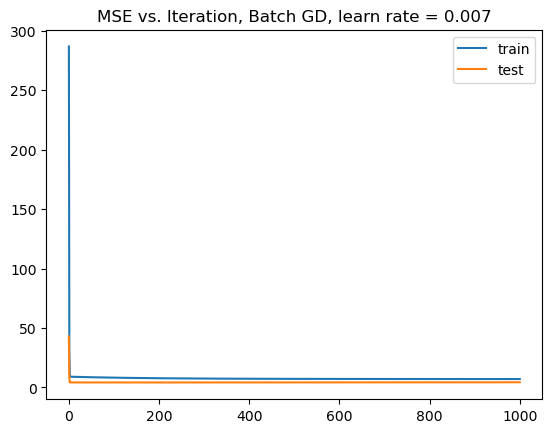

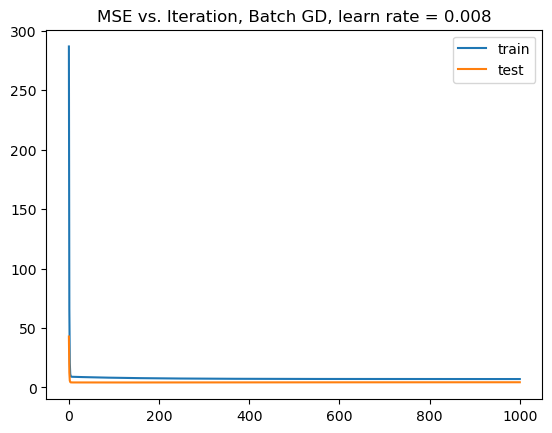

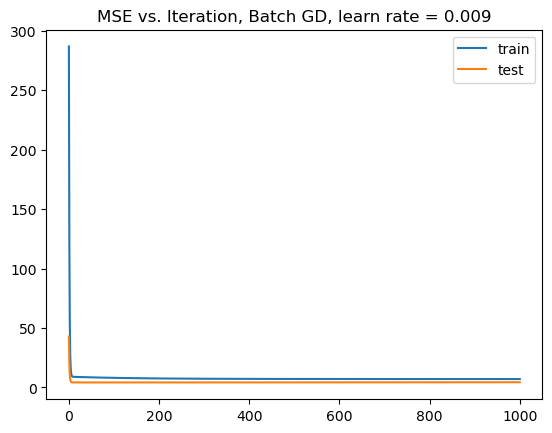

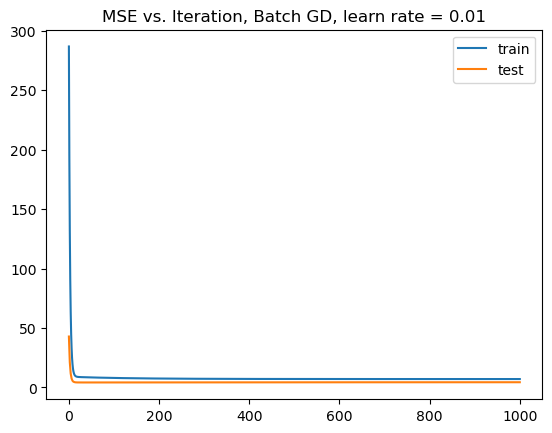

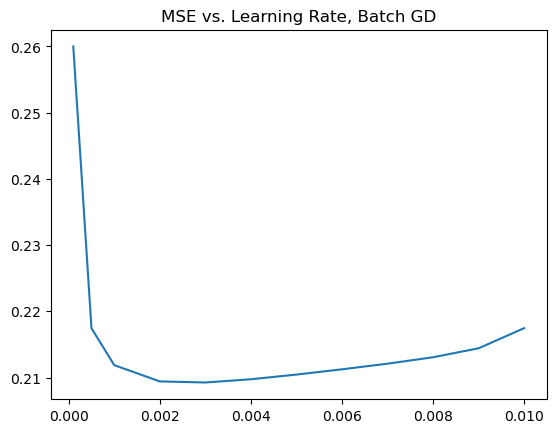

In [8]:
# WORKING

mse_test_b = {}

for learn in rates:
    gd.learn = learn
    ## Batch GD
    b_test, b_train, batch , pred_b = gd.get_coeff_BGD(X_train, y_train, m_train, m_test, m_train, 
                                                    start,X_test,y_test)
    
    mse_error = np.mean(list(b_test.values()))/m_test
    mse_test_b[learn] = mse_error
    
    plt.plot(b_train.keys(), b_train.values(), label = 'train')
    plt.plot(b_test.keys(), b_test.values(), label = 'test')
    plt.title(f'MSE vs. Iteration, Batch GD, learn rate = {learn}')
    plt.legend()
    plt.show()
    
plt.plot(mse_test_b.keys(),mse_test_b.values())   
plt.title(f'MSE vs. Learning Rate, Batch GD')
plt.show()

# Best learning rate
Based on MSE and convergence, the best learning rate for Batch GD is 0.0001 to 0.002 and the best for Stochastic GD is 0.0001 to 0.004. Overall, SGD was able to perform better at higher learning rates than BGD, but BGD sometimes converged faster at very low learning rates.

## Accuracy on the test set

Batch GD was more accurate overall, since it considers every gradient and takes the steepest route. Stochastic GD is only using one point for estimations at each iteration, so it jumps around more in terms of error. This can be seen in the noisiness of the graphs of MSE vs iterations for stochastic GD compared to the smoother curves of batch GD.

# Speed of convergence

SGD converged faster than BGD. This is due to it randomly sampling points to take the gradient, so it can update the weights quickly and can take larger steps towards the optimal point. Since a tolerance was used as a stopping condition, in most cases SGD was able to reach values within an acceptable range faster than BGD. This makes it preferable for large datasets, or when a good estimate of the optimum value is acceptable; the reduction in accuracy can be ok since it converges faster.